In [1]:
import skfem
from skfem.models.poisson import laplace
from skfem.helpers import grad
import numpy as np

<AxesSubplot:title={'center':'triangle mesh'}>

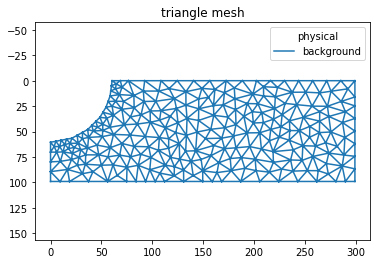

In [2]:
import numpy as np
from skimage.morphology import disk

H, L = 200, 400
Hmid = int(H/2)
Lmid = int(H/2)
r = 60

rectangle = np.ones((H, L))
rectangle[Hmid-r: Hmid+1+r, Lmid-r:Lmid+1+r] -= disk(r)

topright = rectangle[Hmid:, Lmid:]
arr = topright

from nanomesh import Mesher

mesher = Mesher(arr)
mesher.generate_contour(max_edge_dist=5, precision=1)
mesh = mesher.triangulate(opts='q30a100')
triangles = mesh.get('triangle')
triangles.purge(label=2, key='physical')
triangles.plot()

[0. 0.] [ 99. 299.]


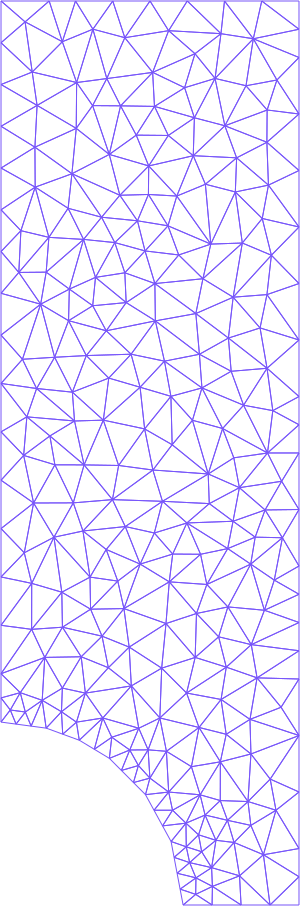

In [3]:
p = triangles.points.T
t = triangles.cells.T

print(p.min(axis=1), p.max(axis=1))

m = skfem.MeshTri(np.ascontiguousarray(p), np.ascontiguousarray(t))
m

In [4]:
def load_func(x, y):
    return 100.

@skfem.LinearForm
def load(v, w):
    x, y = w.x
    return load_func(x, y) * v

def eval_estimator(m, u):    
    # interior residual
    basis = skfem.Basis(m, e)
    
    @skfem.Functional
    def interior_residual(w):
        h = w.h
        x, y = w.x
        return h ** 2 * load_func(x, y) ** 2

    eta_K = interior_residual.elemental(basis, w=basis.interpolate(u))
    
    # facet jump
    fbasis = [skfem.InteriorFacetBasis(m, e, side=i) for i in [0, 1]]
    w = {'u' + str(i + 1): fbasis[i].interpolate(u) for i in [0, 1]}
    
    @skfem.Functional
    def edge_jump(w):
        h = w.h
        n = w.n
        dw1 = grad(w['u1'])
        dw2 = grad(w['u2'])
        return h * ((dw1[0] - dw2[0]) * n[0] +
                    (dw1[1] - dw2[1]) * n[1]) ** 2

    eta_E = edge_jump.elemental(fbasis[0], **w)
    
    tmp = np.zeros(m.facets.shape[1])
    np.add.at(tmp, fbasis[0].find, eta_E)
    eta_E = np.sum(.5 * tmp[m.t2f], axis=0)
    
    return eta_K + eta_E 

<IPython.core.display.Javascript object>


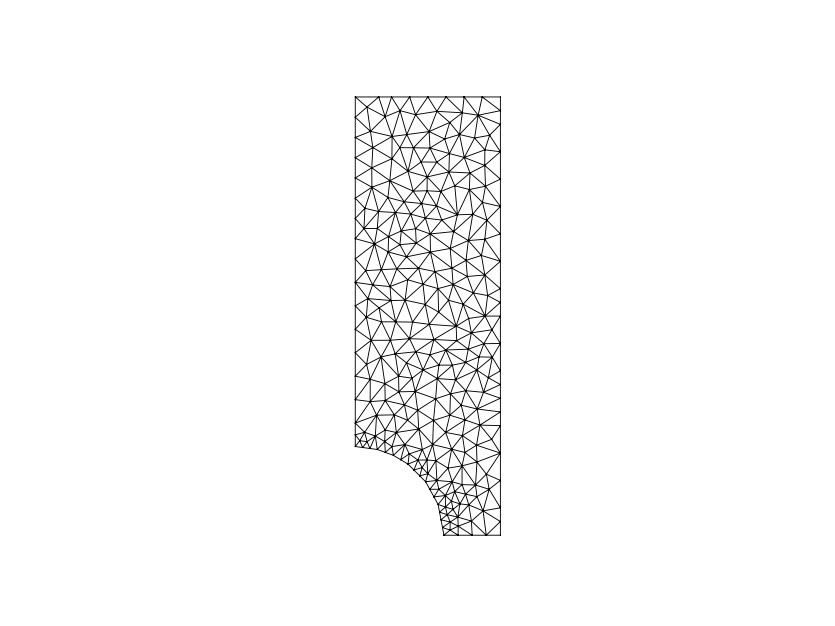

In [5]:
%matplotlib notebook
from skfem.visuals.matplotlib import draw
ax = draw(m)

In [6]:
e = skfem.ElementTriP1()

for itr in reversed(range(10)):
    basis = skfem.Basis(m, e)

    K = skfem.asm(laplace, basis)
    f = skfem.asm(load, basis)

    I = m.interior_nodes()
    u = skfem.solve(*skfem.condense(K, f, I=I))

    if itr > 0:
        m = m.refined(skfem.adaptive_theta(eval_estimator(m, u))).smoothed()

Initializing CellBasis(MeshTri1, ElementTriP1)
Initializing finished.
Assembling 'laplace'.
Assembling finished.
Assembling 'load'.
Assembling finished.
Solving linear system, shape=(203, 203).
Solving done.
Initializing CellBasis(MeshTri1, ElementTriP1)
Initializing finished.
Initializing InteriorFacetBasis(MeshTri1, ElementTriP1)
Initializing finished.
Initializing InteriorFacetBasis(MeshTri1, ElementTriP1)
Initializing finished.
Initializing CellBasis(MeshTri1, ElementTriP1)
Initializing finished.
Assembling 'laplace'.
Assembling finished.
Assembling 'load'.
Assembling finished.
Solving linear system, shape=(208, 208).
Solving done.
Initializing CellBasis(MeshTri1, ElementTriP1)
Initializing finished.
Initializing InteriorFacetBasis(MeshTri1, ElementTriP1)
Initializing finished.
Initializing InteriorFacetBasis(MeshTri1, ElementTriP1)
Initializing finished.
Initializing CellBasis(MeshTri1, ElementTriP1)
Initializing finished.
Assembling 'laplace'.
Assembling finished.
Assembling 'loa

<IPython.core.display.Javascript object>


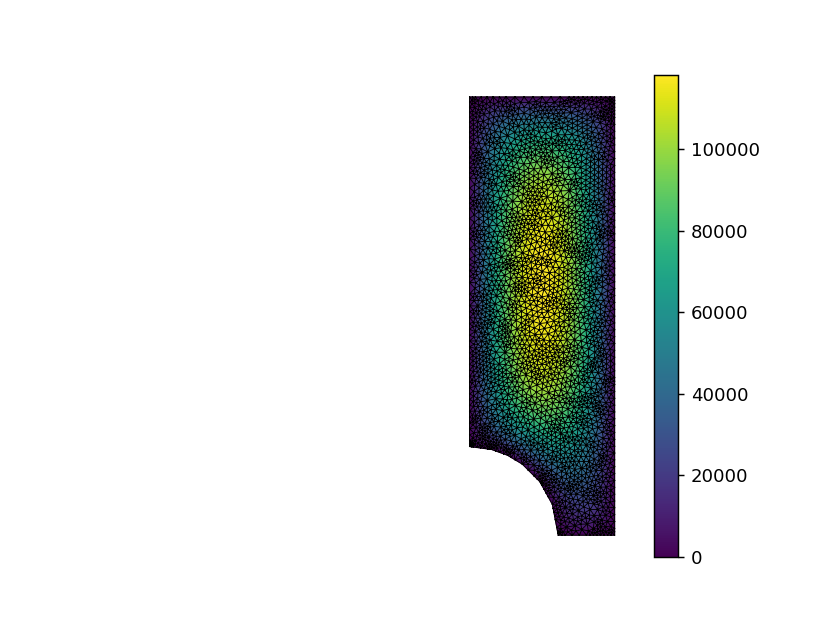

<AxesSubplot:>

In [7]:
def visualize():
    from skfem.visuals.matplotlib import draw, plot
    ax = draw(m)
    return plot(m, u, ax=ax, shading='gouraud', colorbar=True)

visualize()